In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime, date, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

for table in inspector.get_table_names():
    columns = inspector.get_columns(table)
    for c in columns:
        print(table, c['name'], c["type"])

measurement id INTEGER
measurement station TEXT
measurement date TEXT
measurement prcp FLOAT
measurement tobs FLOAT
station id INTEGER
station station TEXT
station name TEXT
station latitude FLOAT
station longitude FLOAT
station elevation FLOAT


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# engine.execute("SELECT * FROM measurement WHERE date BETWEEN '2016-08-01' AND '2017-08-23'").fetchall()
# Calculate the date 1 year ago from the last data point in the database
floor_date = datetime.strptime(session.query(Measurement.date).\
    order_by(Measurement.date.desc()).limit(1).scalar()
    ,'%Y-%m-%d')
ceiling_date = date(floor_date.year -1, floor_date.month, floor_date.day).strftime('%Y-%m-%d')
print (ceiling_date)

2016-08-23


In [64]:
# Perform a query to retrieve the data and precipitation scores
#Select only the date and prcp values
sel = [Measurement.date
       , func.max(Measurement.prcp).label('precipitation')]

# Save the query results as a Pandas DataFrame and set the index to the date column
#Load the query results into a Pandas DataFrame and set the index to the date column
qry = session.query(*sel).\
    filter(Measurement.date >= ceiling_date).\
    filter(Measurement.date <= floor_date).\
    group_by(Measurement.date).\
    statement.compile()

df = pd.read_sql_query(qry, session.bind)
df.set_index('date', inplace=True)

# Sort the dataframe by date
#Sort the DataFrame values by date
df.sort_values(by=['date'], inplace=True)
df.head()

,precipitation
date,
2016-08-23,1.79
2016-08-24,2.28
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18


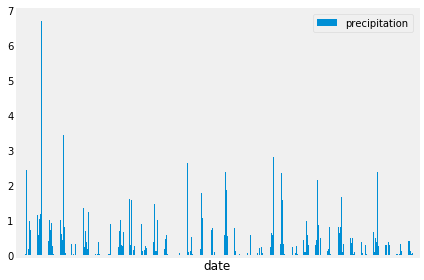

In [62]:
# Use Pandas Plotting with Matplotlib to plot the data
#Plot the results using the DataFrame plot method
df.plot.bar()
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.xlabel('date')
plt.tight_layout()
plt.grid()
plt.show()

![precipitation](Images/precipitation.png)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data

![describe](Images/describe.png)

In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
# engine.execute('SELECT station, COUNT(*) AS countOfStation FROM measurement GROUP BY station ORDER BY countOfStation DESC').fetchall()
sel = [Measurement.station, func.count(Measurement.station)]
session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
# engine.execute("SELECT min(tobs), max(tobs), avg(tobs) FROM measurement WHERE station = 'USC00519281'").fetchall()
most_active_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    limit(1).scalar()

sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
session.query(*sel).\
    filter(Measurement.station == most_active_station).\
    group_by(Measurement.station).\
    all()

[(54.0, 85.0, 71.66378066378067)]

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# engine.execute(f"SELECT max(date) FROM measurement WHERE station = 'USC00519281'").fetchall()

floor_date_for_most_active_station = datetime.strptime(session.query(func.max(Measurement.date)).\
    filter(Measurement.station == most_active_station).scalar()
    ,'%Y-%m-%d')

ceiling_date_for_most_active_station = date(floor_date_for_most_active_station.year -1
                                            , floor_date_for_most_active_station.month
                                            , floor_date_for_most_active_station.day).strftime('%Y-%m-%d')
ceiling_date_for_most_active_station
print(ceiling_date_for_most_active_station)

2016-08-18


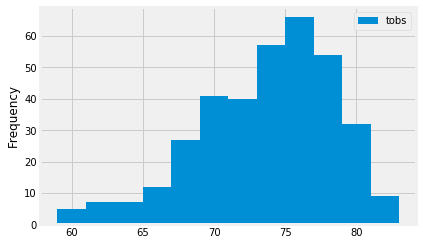

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Filter by the station with the highest number of observations.
# df = pd.read_sql_query(f"SELECT station, date, tobs FROM measurement WHERE station = '{most_active_station}' AND date >= '{ceiling_date_for_most_active_station}' ORDER BY date", session.bind)

sel = [Measurement.date, Measurement.tobs]
qry = session.query(*sel).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= ceiling_date_for_most_active_station).\
    statement.compile()

df = pd.read_sql_query(qry, session.bind)

#Plot the results as a histogram with bins=12.
df.plot.hist(bins=12)

![precipitation](Images/station-histogram.png)

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs)
                         , func.avg(Measurement.tobs)
                         , func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-06-06'
end_date = '2017-06-20'
calc_temps(start_date, end_date)

[(72.0, 77.0204081632653, 83.0)]

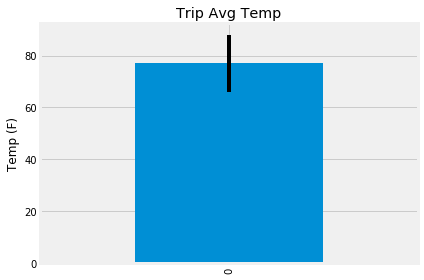

In [30]:
# Plot the results from your previous query as a bar chart. 
columns = ['tmin', 'tavg', 'tmax']
row = list(calc_temps(start_date, end_date)[0])
df = pd.DataFrame({x[0]: x[1] for x in zip(columns, row)}, index=[0])

# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y_error_bar = df.tmax - df.tmin
df.plot(y='tavg', kind='bar', yerr=y_error_bar, grid=True, title='Trip Avg Temp', legend=False)
plt.ylabel('Temp (F)')
plt.tight_layout()
plt.show()


In [31]:
print(start_date, end_date)

2017-06-06 2017-06-20


In [32]:
qry = f"SELECT s.station, s.name, s.latitude, s.longitude, s.elevation, SUM(m.prcp) AS Rainfall FROM station s INNER JOIN measurement m ON m.station = s.station AND m.date BETWEEN '{start_date}' AND '{end_date}' GROUP BY s.station, s.name, s.latitude, s.longitude, s.elevation ORDER BY Rainfall DESC"
engine.execute(qry).fetchall()

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 6.279999999999999),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 3.08),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 2.22),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.1999999999999997),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.6200000000000001),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.21),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

In [33]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Station.station
       , Station.name
       , Station.latitude
       , Station.longitude
       , Station.elevation
       , func.sum(Measurement.prcp).label('Rainfall')]
grp_by = [Station.station
       , Station.name
       , Station.latitude
       , Station.longitude
       , Station.elevation]
session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(*grp_by).\
    order_by(func.sum(Measurement.prcp).desc()).\
    all()


[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  6.279999999999999),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  3.08),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  2.22),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  2.1999999999999997),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.6200000000000001),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.21),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [36]:
def days_between(start_date, end_date):
    """calculates the number of days between two dates
    
    Args:
        start_date and end_date (str): A date string in the format '%Y-%m-%d'
        
    Returns:
        An int being the number of days between two dates
    
    """
    
    d1 = datetime.strptime(start_date, "%Y-%m-%d")
    d2 = datetime.strptime(end_date, "%Y-%m-%d")
    return abs((d2 - d1).days)

In [37]:
def get_trip_dates(start_date, end_date):
    """returns a list of days formatted as '%m-%d' between two dates inclusive of both dates
    
    Args:
        start_date and end_date (str): A date string in the format '%Y-%m-%d'
        
    Returns:
        A list of days formatted as '%Y-%m-%d' between two dates inclusive of both dates
    
    """
    list_trip_dates = []
    for x in range(days_between(start_date, end_date) + 1):
        trip_date = ((datetime.strptime(start_date, "%Y-%m-%d") + timedelta(days=x)))
        list_trip_dates.append(trip_date)   
    return list_trip_dates


In [38]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Strip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
#start_date = '2018-01-01'
#end_date = '2018-01-07'
trip_dates = get_trip_dates(start_date, end_date)

normals = []
for x in range(len(trip_dates)):
    normal = list(daily_normals(trip_dates[x].strftime("%m-%d"))[0])
    normals.append(normal)
normals

[[70.0, 75.17543859649123, 80.0],
 [68.0, 75.07142857142857, 81.0],
 [70.0, 75.58620689655173, 81.0],
 [69.0, 75.15254237288136, 81.0],
 [68.0, 75.14285714285714, 81.0],
 [69.0, 76.01960784313725, 84.0],
 [66.0, 75.66666666666667, 83.0],
 [68.0, 75.66666666666667, 81.0],
 [69.0, 75.62711864406779, 81.0],
 [67.0, 75.40350877192982, 81.0],
 [69.0, 75.41379310344827, 81.0],
 [68.0, 74.59322033898304, 81.0],
 [69.0, 74.60344827586206, 80.0],
 [70.0, 75.44067796610169, 82.0],
 [68.0, 73.96491228070175, 85.0]]

In [39]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
columns = ['tmin', 'tavg', 'tmax']
rows = []
for i in range(len(normals)):
    row = {x[0]: x[1] for x in zip(columns, normals[i])}
    rows.append(row)
df = pd.DataFrame(rows)
df['date'] = trip_dates
df = df[['date', 'tmin', 'tavg', 'tmax']]
df.set_index('date', inplace=True)
df

,tmin,tavg,tmax
date,,,
2017-06-06,70.0,75.175439,80.0
2017-06-07,68.0,75.071429,81.0
2017-06-08,70.0,75.586207,81.0
2017-06-09,69.0,75.152542,81.0
2017-06-10,68.0,75.142857,81.0
2017-06-11,69.0,76.019608,84.0
2017-06-12,66.0,75.666667,83.0
2017-06-13,68.0,75.666667,81.0
2017-06-14,69.0,75.627119,81.0


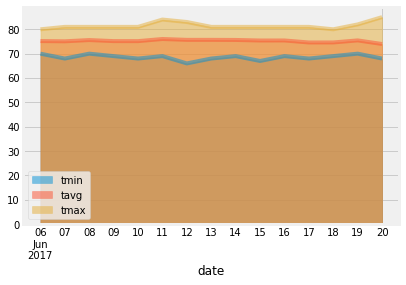

In [40]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked=False, grid=True)